# Modulo principal, já temos a base de dados Amostra pronta, e farei a a mineiração dos dados dos campos necessários para executar o Modelo de Previsão de Seerie Temporais, o Prophet:
## 1) Campo Data da Aplicação da Vacina ('ds')
## 2) Campo Data Descricao Dose 1. Dose e 2. Dose ('y')

In [ ]:
# DATA de Atualização; 26/5/2021

In [1]:
# Importando as principais Bibliotecas:

import csv
import time
import requests 
import pandas  as pd
import seaborn as sns
from random   import random
from prophet  import Prophet
from datetime import datetime
from datetime import date


# Importar bibliotecas para construir gráficos:

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Bibliotecas de Algoritmos de Regressão:

from sklearn.tree            import DecisionTreeClassifier
from catboost                import CatBoostClassifier
from sklearn.metrics         import accuracy_score
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing   import StandardScaler
from sklearn.ensemble        import RandomForestRegressor, ExtraTreesRegressor


# Biblioteca do Prophet para Algoritmo de Previsão:

from prophet      import Prophet
from prophet.plot import plot_plotly
from prophet.plot import plot_components_plotly
from prophet.plot import add_changepoints_to_plot


# Leitura Banco Dados da Amostra no dia 26/05/2021:

df = pd.read_csv("BD_Amostra-Alguns-19-05-2021.csv", sep=";")
usecols   = ['vacina_fabricante_nome',
             'paciente_idade',
             'paciente_id',
             'vacina_dataAplicacao',
             'paciente_endereco_uf',
             'vacina_descricao_dose']



In [2]:
# Definindo Variaveis Globais:

FATOR_AMOSTRA = 0.001 # É o valor da porcentagem obtida pelo Banco de Dados Amostra: 1/1000

# Primeiro passo: 

## Preparando o campo para o datetime: formato = %Y-%m-%dT%H:%M:%S"
## Denifir que o campo 'vacina_dataAplicacao' terá somente a DATA no formato: AAAA/MM/DD
## Remover o TimeZone do campo DATA


In [3]:
# converter a coluna datetime  somente em date

df['vacina_dataAplicacao'] = pd.to_datetime(df['vacina_dataAplicacao']).dt.date


df.dtypes


vacina_fabricante_nome    object
paciente_idade             int64
paciente_id               object
vacina_dataAplicacao      object
paciente_endereco_uf      object
vacina_descricao_dose     object
dtype: object

In [5]:
df['vacina_dataAplicacao']

0        2021-01-21
1        2021-02-12
2        2021-03-29
3        2021-04-13
4        2021-03-09
            ...    
50822    2021-05-08
50823    2021-05-12
50824    2021-05-12
50825    2021-05-12
50826    2021-05-03
Name: vacina_dataAplicacao, Length: 50827, dtype: object

# Segundo Passo: 
## Tratando do campo "vacina_descricao_dose" teremos os seguintes casos:
##   - Primeira Dose 
##   - Segunda Dose após um intervalo definido
##   - Dose única

In [6]:
df["vacina_descricao_dose"].unique()


array(['\xa0\xa0\xa0\xa01ª\xa0Dose', '\xa0\xa0\xa0\xa02ª\xa0Dose',
       '1ª Dose', '2ª Dose', 'Única'], dtype=object)

In [65]:
# Note que o conteúdo do campo "data_descricao_dose" contém os caracteres:

# array(['\xa0\xa0\xa0\xa01ª\xa0Dose', 
#        '\xa0\xa0\xa0\xa02ª\xa0Dose']
#        '1ª Dose', '2ª Dose', 'Única'



In [7]:
# Tratando o campo "vacina_descricao_dose":

# 1) Transformando todos as linhas como Minuúsculas
# 2) Quando aparecer Null (NaN) substitui-se por "-"
# 3) Tratando todos os caracteres ASCII 

df["vacina_descricao_dose"] = (df["vacina_descricao_dose"]
                                 .str.lower()
                                 .str.normalize("NFKD")
                                 .str.lstrip()
                                 .str.replace(" ","_")
                                 .str.encode("ascii", errors="ignore")
                                 .str.decode("utf-8"))

# Terceiro Passo: 

## Vou tratar o campo 'vacina_descricao_dose':

## Teremos 3 situações para contabilizar o número de vacinas tomadas:
##  (1) A Primeira Dose ==> 1a_dose
##  (2) A Segunda Dose  ==> Totalmente vacinados com a  2a_dose
##  (3) Ser Dose Unica!!

In [6]:
# A dose unica aparece como valor = 1

# OBS: A vacina Jassen da Johnson&Johnson é somente 1 Dose
# df.loc[df["vacina_descricao_dose"] == 'unica', "vacina_descricao_dose" ] =  '1a_dose'

In [8]:
df["vacina_descricao_dose"].value_counts()


1a_dose    34682
2a_dose    16144
unica          1
Name: vacina_descricao_dose, dtype: int64

# Quarto Passo:

## Usando a função: Get_Dummies para descrever o campo 'vacina_descricao_dose':

## se não tomou vacina da 1ª Dose' = 0, se tomou a 1ª Dose' = 1
## se não tomou vacina da 2ª Dose' = 0, se tomou a 2ª Dose' = 1



In [9]:

dummies = df["vacina_descricao_dose"].str.get_dummies("\n")


In [10]:
# Concatenar com o DataFrame e a coluna Dummies:

df = pd.concat([df, dummies], axis = 1)

In [11]:
dummies.head(5)

,1a_dose,2a_dose,unica
0,1,0,0
1,1,0,0
2,1,0,0
3,0,1,0
4,0,1,0


<AxesSubplot:xlabel='count', ylabel='vacina_descricao_dose'>

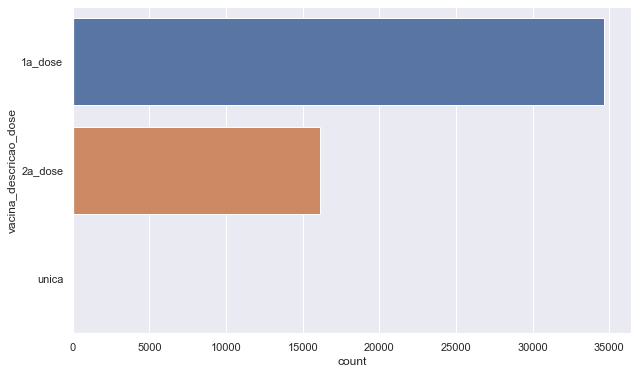

In [10]:
plt.figure(figsize = (10,6))
sns.countplot(data = df, y = "vacina_descricao_dose")

In [12]:
Vacinados_uma_dose = df['1a_dose'].sum()

print('Total de Vacinados com 1. dose = ', Vacinados_uma_dose/FATOR_AMOSTRA)

Total de Vacinados com 1. dose =  34682000.0


In [13]:
Vacinados_duas_doses = df['2a_dose'].sum()

print('Total de Vacinados com 2. dose = ', Vacinados_duas_doses/FATOR_AMOSTRA)

Total de Vacinados com 2. dose =  16144000.0


In [16]:
# Limpando os campos das Doses, retirando os nulos NaN

df['1a_dose'].fillna(0, inplace = True)

df['2a_dose'].fillna(0, inplace = True)

# Quinto Passo: 

## Trabalhando com informações da '1a_dose' para rodar a PREVISAO:

In [17]:
df1 = df.groupby('vacina_dataAplicacao').agg({'1a_dose':'sum'}).reset_index()

df1['vacina_dataAplicacao'].value_counts()


2021-03-23    1
2021-05-02    1
2021-03-08    1
2021-02-15    1
2021-01-26    1
             ..
2021-02-22    1
2021-03-10    1
2021-03-07    1
2021-01-18    1
2021-03-20    1
Name: vacina_dataAplicacao, Length: 116, dtype: int64

# Sexto Passo: 

## Usar o Algoritmo do Prophet para Previsao Séries Temporais: dois campos importantes 'ds' e 'y'

## ds => é a coluna DATA e já está no formato de AAAA-MM-DD

## A coluna y => deve ser numérica e representa a medida que desejamos prever
## y = total da 1. dose para dataframe ==> df1 
##     ou 2.dose para dataframe        ==> df2

In [18]:
# Renomeando as colunas para preparar para rodar o Modelo Prophet:

df1.columns = ['ds', 'y']

In [21]:
df1.head(3)

,ds,y
0,2021-01-17,1
1,2021-01-18,0
2,2021-01-19,78


In [22]:
df1.ds.max()

datetime.date(2021, 5, 12)

In [23]:
# Plotting the TIme Series Data

<AxesSubplot:title={'center':'Tempo de Data Series'}, xlabel='ds'>

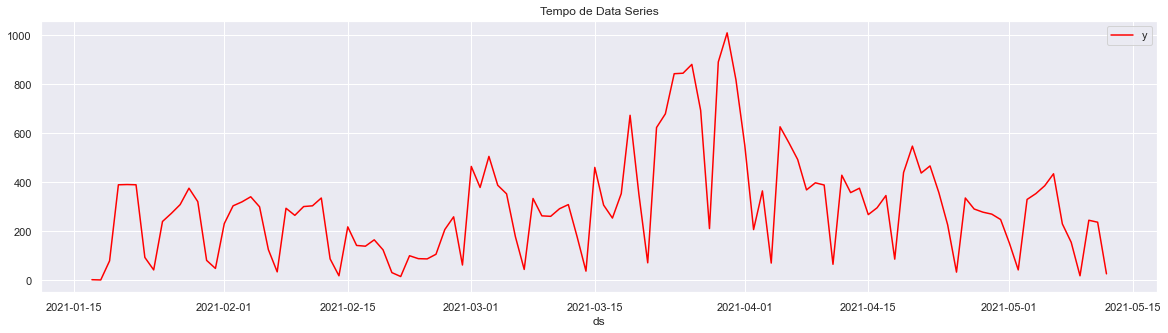

In [19]:
df1.plot(x ='ds', y ='y', figsize = (20,5), title = 'Tempo de Data Series' , color = 'red')

# Sétimo Passo: 
## Definifindo a sazonalidade dos períodos: diario, mensal, anual ou quinzenal:

In [20]:
# Definindo a sazonalidade diaria, semanal e mensal terá mais controle sobre a sazonalidade. 



model = Prophet(daily_seasonality      = False,
               weekly_seasonality      = False,
               yearly_seasonality      = False,
               ).add_seasonality(name= 'mounthly',
                                 period = 30,
                                 fourier_order = 12
                ).add_seasonality(name = 'dayly',
                                 period = 1,
                                 fourier_order = 15
                                 ).add_seasonality(name = 'weekly',
                                 period = 7,
                                 fourier_order = 20,
                ).add_seasonality(name= 'yearly',
                                 period = 365.25,
                                 fourier_order = 20
                ).add_seasonality(name= 'quartely',
                                 period = 365.25/4,
                                 fourier_order = 5,
                                 prior_scale = 15)
                

# Finalizando:

## Definindo parâmetros do Prophet(), assegurando que teremos a previsão positiva:



In [24]:
# Fazendo Previsoes com Saturacoes:

# Prophet usa um modelo linear para sua previsao, e podemos usar um modelo de  tendência 
# de crescimento logística, 'growth = logistic'

# Deve-se especificar a capacidade de suporte em uma coluna 'cap', parametro cap = 10

df1['cap'] = 10

# Assim, nosso Dataframe conterá as colunas, para o Modelo Prophet():

df1.head(5)

,ds,y,cap
0,2021-01-17,1,10
1,2021-01-18,0,10
2,2021-01-19,78,10
3,2021-01-20,389,10
4,2021-01-21,390,10


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


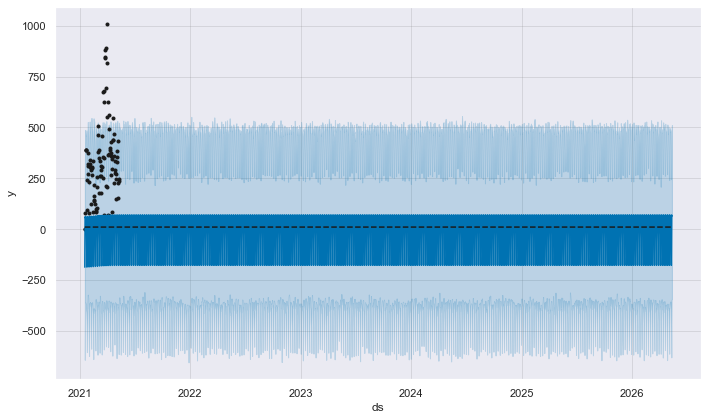

In [25]:
# Configurando growth = Logistic:

model = Prophet(growth = 'logistic')

# Fazendo .fit:
model.fit(df1)

future = model.make_future_dataframe(periods = 1826)
future['cap'] = 10
forecast = model.predict(future)




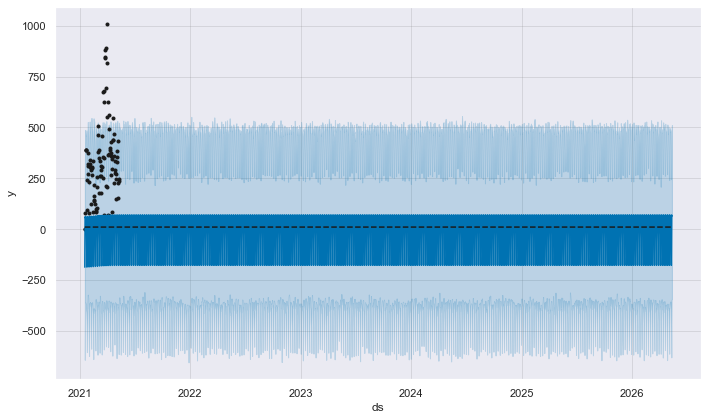

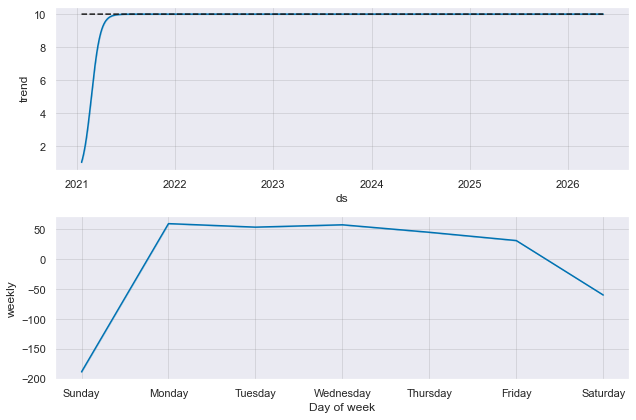

In [26]:
# Fazendo o Plotagem:

fig = model.plot(forecast)

fig = model.plot_components(forecast)

In [46]:
# Explicando as métricas:

# yhat: o valor previsto de nossa métrica (em Estatísticas, 
#       yhat é uma notação tradicionalmente usada para representar os valores previstos de um valor y)

# yhat_lower: o limite inferior de nossas previsões
# yhat_upper: o limite superior de nossas previsões


forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1937,2026-05-08,41.402647,-362.693584,513.178908
1938,2026-05-09,-49.650678,-504.189786,388.141300
1939,2026-05-10,-178.182361,-593.631549,276.509103
1940,2026-05-11,69.685357,-378.369632,478.619622
1941,2026-05-12,63.807581,-363.185477,488.159608


In [47]:
# Todos os campos da Previsão:

forecast

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-17,1.036047,10,-607.654593,255.894784,1.036047,1.036047,-188.182361,-188.182361,-188.182361,-188.182361,-188.182361,-188.182361,0.0,0.0,0.0,-187.146314
1,2021-01-18,1.092173,10,-364.217140,484.362607,1.092173,1.092173,59.685357,59.685357,59.685357,59.685357,59.685357,59.685357,0.0,0.0,0.0,60.777529
2,2021-01-19,1.150948,10,-414.722955,484.841017,1.150948,1.150948,53.807581,53.807581,53.807581,53.807581,53.807581,53.807581,0.0,0.0,0.0,54.958530
3,2021-01-20,1.212457,10,-362.436563,479.398697,1.212457,1.212457,57.719749,57.719749,57.719749,57.719749,57.719749,57.719749,0.0,0.0,0.0,58.932206
4,2021-01-21,1.276778,10,-359.984411,444.956506,1.276778,1.276778,45.217704,45.217704,45.217704,45.217704,45.217704,45.217704,0.0,0.0,0.0,46.494481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1937,2026-05-08,10.000000,10,-362.693584,513.178908,10.000000,10.000000,31.402647,31.402647,31.402647,31.402647,31.402647,31.402647,0.0,0.0,0.0,41.402647
1938,2026-05-09,10.000000,10,-504.189786,388.141300,10.000000,10.000000,-59.650678,-59.650678,-59.650678,-59.650678,-59.650678,-59.650678,0.0,0.0,0.0,-49.650678
1939,2026-05-10,10.000000,10,-593.631549,276.509103,10.000000,10.000000,-188.182361,-188.182361,-188.182361,-188.182361,-188.182361,-188.182361,0.0,0.0,0.0,-178.182361
1940,2026-05-11,10.000000,10,-378.369632,478.619622,10.000000,10.000000,59.685357,59.685357,59.685357,59.685357,59.685357,59.685357,0.0,0.0,0.0,69.685357


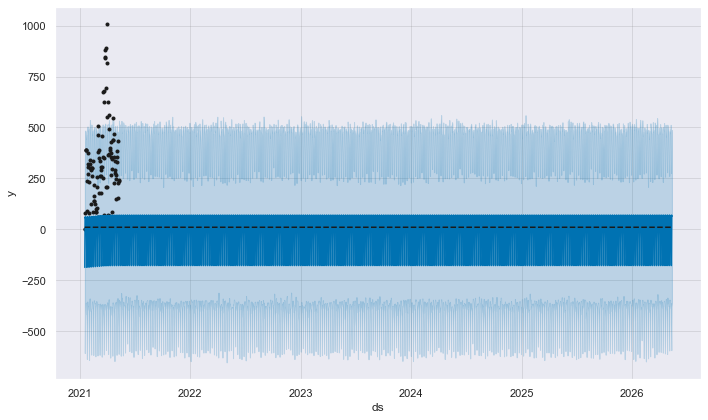

In [48]:
fig = model.plot(forecast)

<AxesSubplot:title={'center':'Atual X Futuro'}, xlabel='ds'>

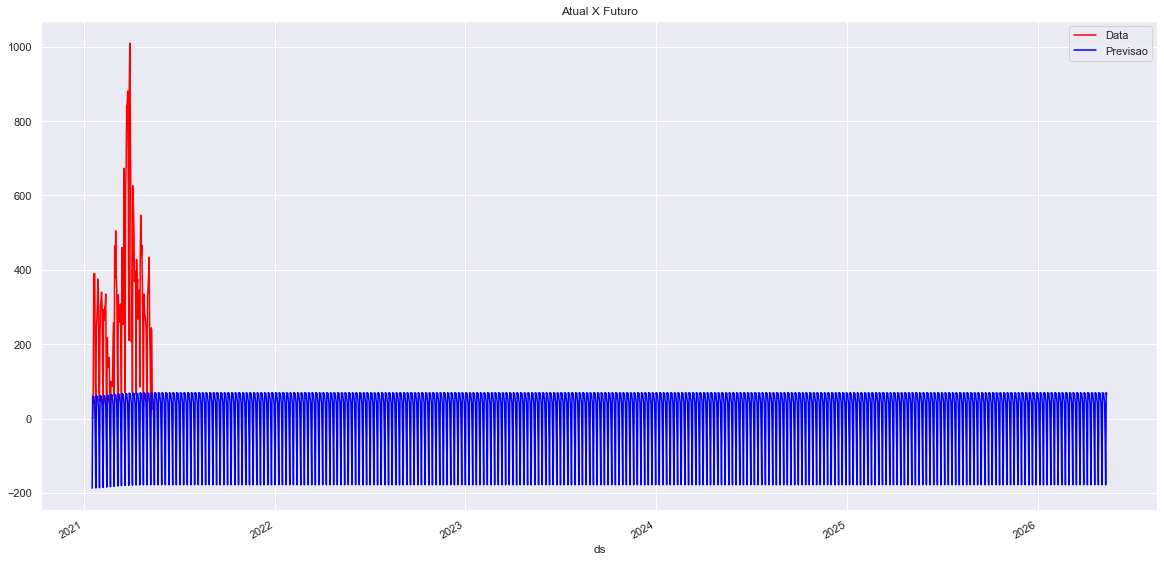

In [63]:
# plotting valores Atual e Futuro: 

ax = (df1.plot(x= 'ds', y = 'y',   legend = True, label = 'Data', figsize=(20,10), color = 'red')) 
forecast.plot(x= 'ds',  y ='yhat', legend = True, label = 'Previsao', figsize=(20,10),title='Atual X Futuro', color ='blue',ax=ax)



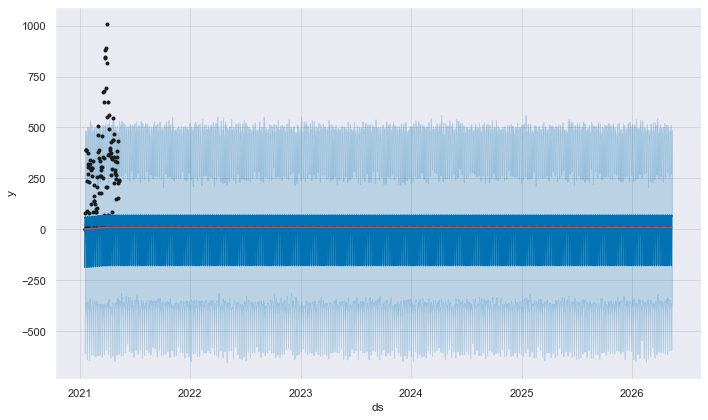

In [54]:
fig = model.plot(forecast)
a   = add_changepoints_to_plot(fig.gca(), model, forecast)

# Aqui estarei fazendo as Previsões da Segunda Dose da Vacina:

In [34]:
df2 = df.groupby('vacina_dataAplicacao').agg({'2a_dose':'sum'}).reset_index()

df2['vacina_dataAplicacao'].value_counts()


2021-03-23    1
2021-05-02    1
2021-03-08    1
2021-02-15    1
2021-01-26    1
             ..
2021-02-22    1
2021-03-10    1
2021-03-07    1
2021-01-18    1
2021-03-20    1
Name: vacina_dataAplicacao, Length: 116, dtype: int64

In [35]:
# Renomeando as colunas para preparar para rodar o Modelo Prophet:

df2.columns = ['ds', 'y']

In [36]:
df2

,ds,y
0,2021-01-17,0
1,2021-01-18,1
2,2021-01-19,0
3,2021-01-20,0
4,2021-01-21,1
...,...,...
111,2021-05-08,41
112,2021-05-09,7
113,2021-05-10,145
114,2021-05-11,118


<AxesSubplot:title={'center':'Datas Vacinação da 2. Dose'}, xlabel='ds'>

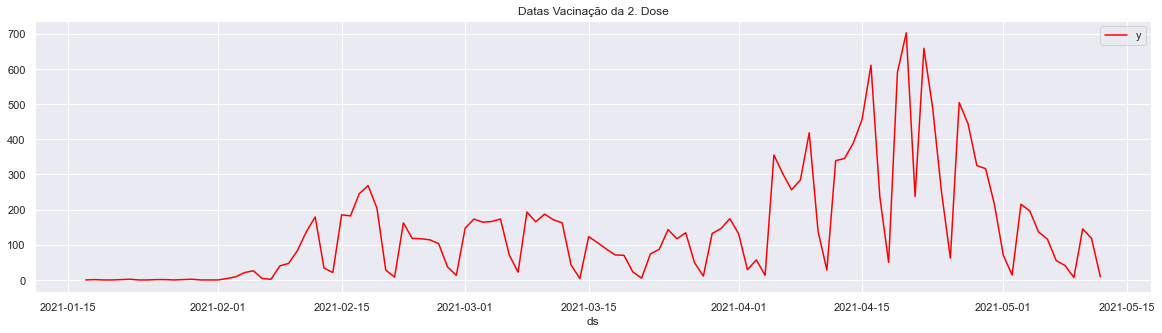

In [39]:
df2.plot(x ='ds', y ='y', figsize = (20,5), title = 'Datas Vacinação da 2. Dose' , color = 'red')

In [37]:
# Fazendo Previsões com Saturacoes:

# Prophet usa um modelo linear para sua previsao, e podemos usar um modelo de  tendência 
# de crescimento logística, 'growth = logistic'

# Deve-se especificar a capacidade de suporte em uma coluna 'cap', parametro cap = 10

df2['cap'] = 10

# Assim, nosso Dataframe conterá as colunas, para o Modelo Prophet():

df2.head(5)

,ds,y,cap
0,2021-01-17,0,10
1,2021-01-18,1,10
2,2021-01-19,0,10
3,2021-01-20,0,10
4,2021-01-21,1,10


# Rodando o Algorítmo de Previsao PROPHETS para '2a_dose'

In [40]:
# Definindo a sazonalidade diaria, semanal e mensal terá mais controle sobre a sazonalidade. 



model = Prophet(daily_seasonality      = False,
               weekly_seasonality      = False,
               yearly_seasonality      = False,
               ).add_seasonality(name= 'mounthly',
                                 period = 30,
                                 fourier_order = 12
                ).add_seasonality(name = 'dayly',
                                 period = 1,
                                 fourier_order = 15
                                 ).add_seasonality(name = 'weekly',
                                 period = 7,
                                 fourier_order = 20,
                ).add_seasonality(name= 'yearly',
                                 period = 365.25,
                                 fourier_order = 20
                ).add_seasonality(name= 'quartely',
                                 period = 365.25/4,
                                 fourier_order = 5,
                                 prior_scale = 15)
                

# Prepara o Modelo Prophet() e aplica método fit() para '2a_dose'

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


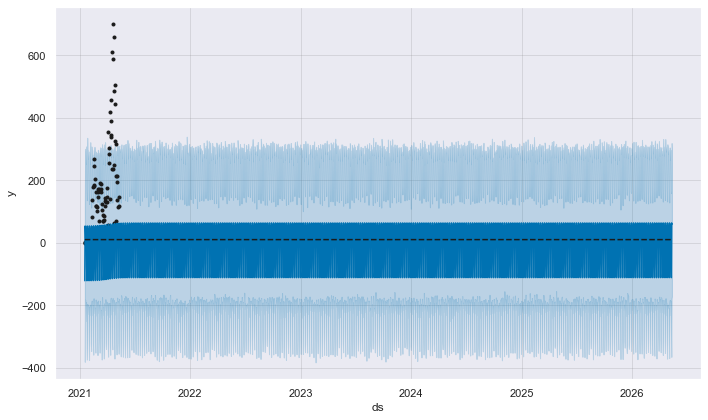

In [42]:
# Configurando growth = Logistic:

model = Prophet(growth = 'logistic')

# Fazendo .fit:
model.fit(df2)

future = model.make_future_dataframe(periods = 1826)
future['cap'] = 10
forecast = model.predict(future)

fig = model.plot(forecast)


In [43]:
# Explicando as métricas:

# yhat: o valor previsto de nossa métrica (em Estatísticas, 
#       yhat é uma notação tradicionalmente usada para representar os valores previstos de um valor y)

# yhat_lower: o limite inferior de nossas previsões
# yhat_upper: o limite superior de nossas previsões


forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1937,2026-05-08,45.053196,-210.997460,297.280333
1938,2026-05-09,-66.042714,-304.315100,167.617281
1939,2026-05-10,-111.878238,-365.630722,159.031323
1940,2026-05-11,63.472353,-178.476386,319.330659
1941,2026-05-12,59.227110,-172.376994,302.153768


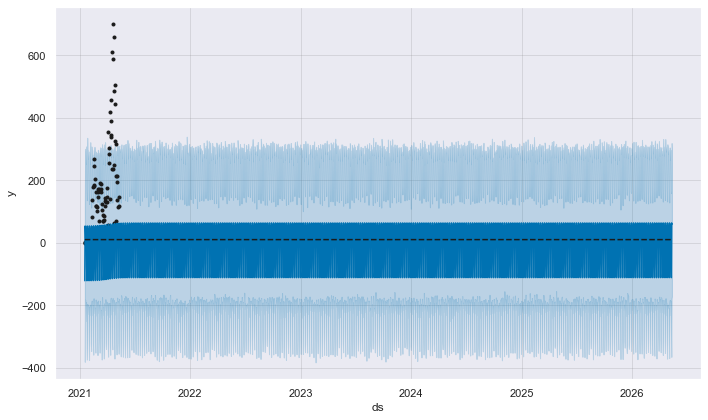

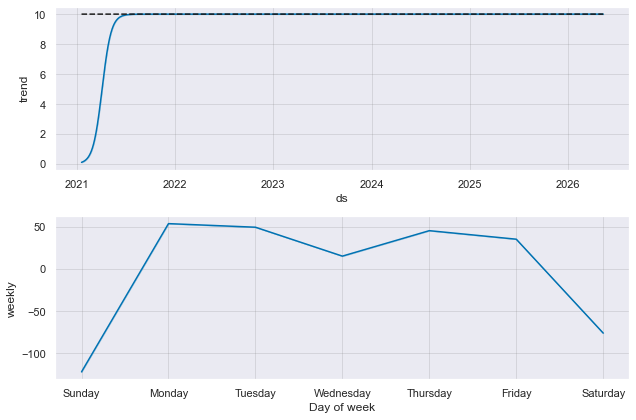

In [44]:
# Fazendo o Plotagem:

fig = model.plot(forecast)

fig = model.plot_components(forecast)